# SAMap zebrafish Farrell 5.3 - 9 hpf vs amphioxus G4 - N2 preprocess
With leiden-based neighborhoods

Zebrafish proteins

In [1]:
from samap.mapping import SAMAP
from samap.analysis import (get_mapping_scores, GenePairFinder, sankey_plot, chord_plot, CellTypeTriangles, 
                            ParalogSubstitutions, FunctionalEnrichment,
                            convert_eggnog_to_homologs, GeneTriangles)
from samalg import SAM
import pandas as pd
import numpy
import seaborn as sns
import csv
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import scanpy as sc
import anndata as ad
import warnings
warnings.filterwarnings(action='ignore')
import pickle

def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

## Concatenating h5ad files

In [2]:
amp_adata=ad.concat({'G4':ad.read_h5ad('../../input_data/Amp_h5ad/Amp_G4.h5ad'),
                    'N0':ad.read_h5ad('../../input_data/Amp_h5ad/Amp_N0.h5ad'),
                    'N2':ad.read_h5ad('../../input_data/Amp_h5ad/Amp_N2.h5ad')},label='stage')
amp_adata.write('amp_G4_N2.h5ad')
zf_adata=ad.concat({'hpf5':ad.read_h5ad('../../input_data/zf_farrell5.3_ZF50.h5ad'),
                    'hpf7':ad.read_h5ad('../../input_data/zf_farrell7_ZF60.h5ad'),
                    'hpf8':ad.read_h5ad('../../input_data/zf_farrell8_ZF75.h5ad'),
                    'hpf9':ad.read_h5ad('../../input_data/zf_farrell9_ZF90.h5ad')},label='stage')
zf_adata.write('zf_5_9_hpf.h5ad')

## Read gene name mapping

Parse mapping of transcript ids vs gene names used in the anndata object

In [3]:
with open('../../../reference/zebra_ens_prot/zf_final_prot_gene_map.csv') as f:
    dr_idmap=[tuple(line) for line in csv.reader(f)][2:]

with open('../../../reference/amp_braflo100_cdna/amp_tr_gene_map.csv') as f:
    bf_idmap=[tuple(line) for line in csv.reader(f)][2:]

print(dr_idmap[:5])
print(bf_idmap[:5])

[('ENSDARP00000000005', 'ccdc80'), ('ENSDARP00000000042', 'mcm6l'), ('ENSDARP00000000069', 'slc9a3r1'), ('ENSDARP00000000070', 'dap'), ('ENSDARP00000000087', 'itsn1')]
[('XM_035817741.1', 'Ppp4r4'), ('XM_035817733.1', 'Ppp4r4'), ('XM_035817723.1', 'Ppp4r4'), ('XM_035817707.1', 'Ppp4r4'), ('XM_035827936.1', 'LOC118420880')]


# Running SAMap

SAMap accepts file paths to unprocessed, raw `.h5ad` files. The only processing that should be done on these files is to remove low-quality cells. Otherwise, they should be completely unprocessed. The gene expressions (`AnnData.X`) should be in `scipy` `sparse` format (e.g. `scipy.sparse.csr_matrix`).

Alternatively, if you already have processed and run `SAM` objects, you can load them into SAMap directly. Below, we will show examples of both.

## Loading in raw data

When loading in raw data, SAMap will automatically process them with SAM and save the results to an `*_pr.h5ad` file. For example, f the raw data is `file.h5ad` the processed data will be saved to `file_pr.h5ad`.

In [4]:
path_dr = 'zf_5_9_hpf.h5ad'
path_amp = 'amp_G4_N2.h5ad'

SAMap expects the above to be in a dictionary keyed by the species IDs determined in the BLAST step:

In [5]:
filenames = {'dr':path_dr,'bf':path_amp}

Instantiate the SAMAP object as below. 

In [6]:
sm = SAMAP(
        filenames,
        f_maps = '../../../reference/maps_prot/maps_ens/',
        names = {'dr' : dr_idmap, 'bf' : bf_idmap},
        #keys = {'dr' : 'TimeID', 'bf' : 'stage'},
        #resolutions = {'dr' : 5, 'bf' : 3},
        save_processed=False #if False, do not save the processed results to `*_pr.h5ad`
    )

Processing data dr from:
zf_5_9_hpf.h5ad
RUNNING SAM
Iteration: 0, Convergence: 1.0
Iteration: 1, Convergence: 0.808101596573522
Iteration: 2, Convergence: 0.015477211226485495
Computing the UMAP embedding...
Elapsed time: 76.37861180305481 seconds
Not updating the manifold...
Processing data bf from:
amp_G4_N2.h5ad
RUNNING SAM
Iteration: 0, Convergence: 1.0
Iteration: 1, Convergence: 0.8551643021658932
Iteration: 2, Convergence: 0.01294199714467075
Computing the UMAP embedding...
Elapsed time: 35.20249271392822 seconds
Not updating the manifold...
13229 `dr` gene symbols match between the datasets and the BLAST graph.
12974 `bf` gene symbols match between the datasets and the BLAST graph.


Show unintegrated umaps

Amphioxus unintegrated


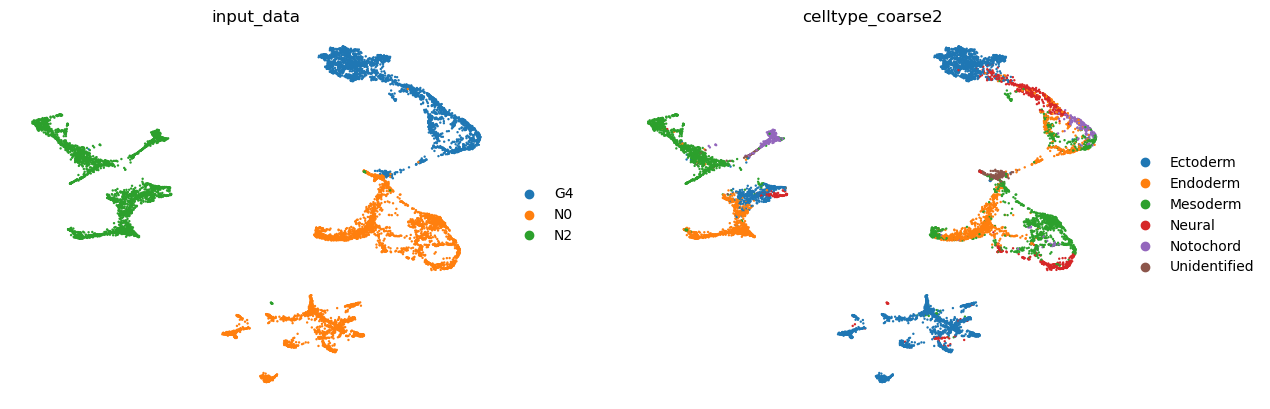

Zebrafish unintegrated


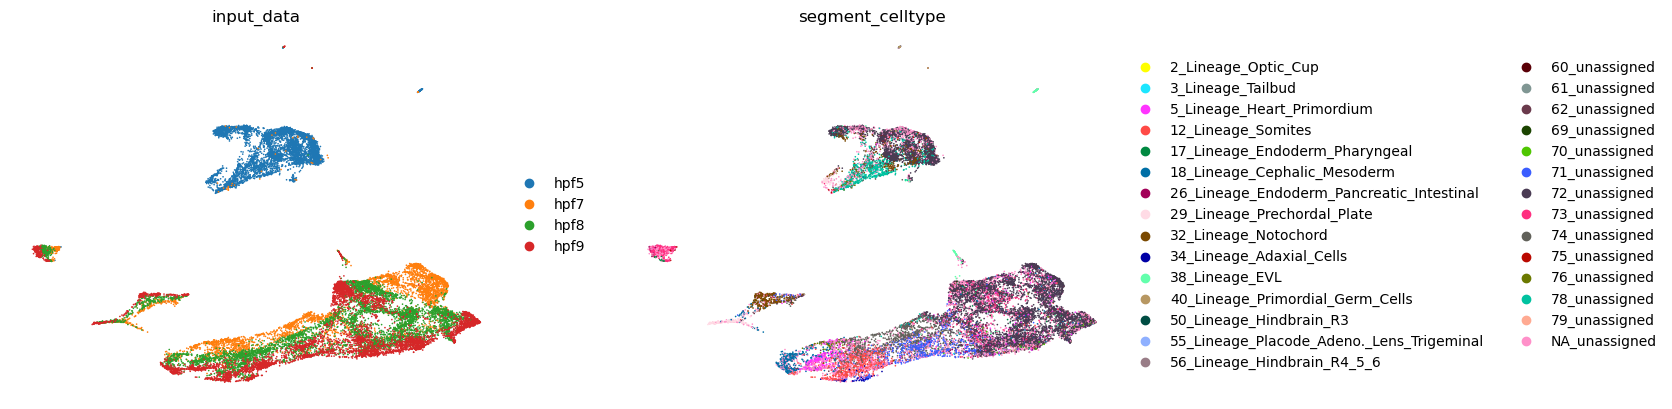

In [10]:
vis_keys_bf=['stage','celltype_coarse2']
vis_keys_dr=['stage','segment_celltype']
print('Amphioxus unintegrated')
sc.pl.embedding(sm.sams['bf'].adata,
                    basis='X_umap',
                    color=vis_keys_bf,
                    frameon=False)
print('Zebrafish unintegrated')
sc.pl.embedding(sm.sams['dr'].adata,
                    basis='X_umap',
                    color=vis_keys_dr,
                    frameon=False)

### Digression: How does SAMap robustly determine cross-species neighbors?

SAMap initially identifies the k-nearest cross-species neighbors for each cell. It then looks at the mutual connectivity between neighborhoods of cells rather than individual cells to determine the connectivity of cells across species.

In this way, even if two cells are NOT directly connected to each other in the initial kNN graph, if their ***neighborhoods*** are connected, then these two cells will be considered as neighboring regardless. The exact edge weight is calculated by looking at the fraction of edges connecting their two neighborhoods.

By default, SAMap identifies neighborhoods within species by hopping along the outgoing edges from each cell in each species' manifold (constructed by SAM). To ensure that the neighborhoods do not get unreasonably large, this "hopping" is truncated by the size of the cluster to which each cell belongs. In other words, each cell's neighborhood will never be bigger than the size of its cluster. In this way, we mitigate scenarios where the neighborhoods of distinct cell types are erroneously merged together.

The clusters are computed using leiden clustering, and the resolution parameter is set to 3 by default. The resolution parameter can be specified using the `resolutions` argument in `SAMAP` as follows:

Finally, rather than determining neighborhood sizes by hopping along each cell's outgoing edges, we can also determine them using the cell type labels. In other words, cells that have the same label all belong to the same neighborhood. This can be set using the `neigh_from_keys` parameter of `SAMAP.run`.

## Run SAMap

In [ ]:
sm.run(ncpus=16)

save samap object

In [ ]:
save_object(sm,'sam_processed.pkl')

# Post-SAMap analysis

Okay, so we were able to produce a SAM object, `samap`, with datasets stitched together.

Some notes about the combined SAM object:
- The expression data in `samap.adata` is a block-diagonal matrix of each species' gene expressions.
- The species ID for each cell is stored in `samap.adata.obs['species']`
- The combined graph is stored in `samap.adata.obs['connectivities']`
- The refined homology graph is stored in `samap.adata.varp['homology_graph_reweighted']` (or `sm.gnnm_refined`) and the gene names corresponding to this graph are stored in `samap.adata.var_names` (or `sm.gns`).

Now, I'll go over some tools I provide to help interpret and visualize your results.


## Visualizing the combined projection

In [ ]:
fig, ax = plt.subplots()
fig.set_figwidth(8)
fig.tight_layout()
ax.set_title('SAMap UMAP amphioxus (red) vs Zebrafish (blue)')
sm.scatter(COLORS={'dr':'#10b9f1','bf':'#f14810'},axes=ax,ss={'bf':5,'dr':5},alpha=0.5)